**Part 2. AI Agent 활용 프로젝트**

- Chapter 03. N개 이상의 Agent

    - **📒[실습]** Clip 04. Network - 학습자의 약점을 기반으로 문제를 생성하는 Agent🗒️

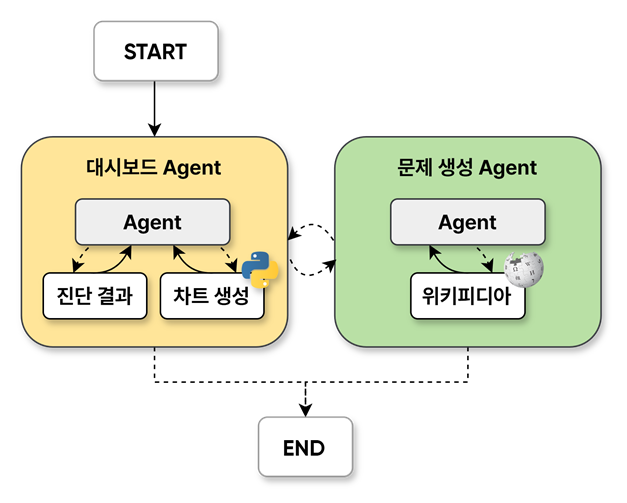

In [1]:
import getpass
import os


def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")


_set_env("OPENAI_API_KEY")

- 공용 시스템 프롬프트

In [2]:
def make_system_prompt(suffix: str) -> str:
    return (
        f"""You are a helpful AI assistant collaborating with other specialized assistants to complete tasks step by step.

        Use the tools provided and make as much progress as possible on the current task. Do not hesitate to take action within your scope.

        There are two clear cases:
        1. If you have fully completed your part of the task *and* no other assistant's help is needed, return your result prefixed with "FINAL ANSWER".
        → This includes cases where you have completed generating questions or producing the final deliverable.
        2. If there are parts of the task that require actions you cannot perform, summarize what you've done and clearly hand off the task to the next assistant.

        \n{suffix}"""
    )

### 문제 생성을 위한 Agent

`pip install wikipedia`

In [3]:
from langchain_community.tools import WikipediaQueryRun
from langchain_community.utilities import WikipediaAPIWrapper

wikipedia = WikipediaQueryRun(api_wrapper=WikipediaAPIWrapper())

In [4]:
wikipedia.run("갑오개혁")

"Page: Kabo Reform\nSummary: The Kabo Reform (Korean: 갑오개혁; Hanja: 甲午改革) describes a series of sweeping reforms suggested to the government of Korea, beginning in 1894 and ending in 1896 during the reign of Gojong of Korea in response to the Donghak Peasant Revolution. Historians debate the degree of Japanese influence in this program, as well as its effect in encouraging modernization.\nThe term Kabo (갑오; 甲午) comes from the name of the year 1894 in the traditional sexagenary cycle.\n\n\n\nPage: Yeongeunmun\nSummary: Yeongeunmun (Korean: 영은문; Hanja: 迎恩門) or Yeongeunmun Gate was a Joseon-era former gate near present day Seoul, South Korea. Since it was a symbol of China's diplomatic influence on the Joseon, the Gaehwa Party of the Joseon government intentionally demolished it in February 1895, seeking complete political independence of Joseon from China.\n\n\n\nPage: Plinths of Yeongeunmun Gate, Seoul\nSummary: The Plinths of Yeongeunmun Gate, Seoul (Korean: 서울 영은문 주초) are one of the Hi

In [5]:
from langchain_openai import ChatOpenAI
from langgraph.prebuilt import create_react_agent

llm = ChatOpenAI(model="gpt-4o")

problem_agent = create_react_agent(
    llm,
    tools=[wikipedia],
    prompt=make_system_prompt(
        "You can only do generate problem. " \
        "You can retrieve information from Wikipedia only when the query is a proper noun — specifically a person (e.g. 'Napoleon'), a country (e.g. 'France'), or a historical event (e.g. 'French Revolution'). " \
        "Do not retrieve for general topics or abstract concepts." \
        "Please give a 5-option multiple choice question and generate in Korean." \
        "Do not return the answer, just the question and options." \
        "You are working with a diagnosis colleague." 
    ),
)

In [6]:
response = problem_agent.invoke(
    {
        "messages": [
            {
                "role": "user",
                "content": "흥선대원군의 업적에 대한 문제를 만들어주세요."
            }
        ]
    }
)
for msg in response["messages"]:
    msg.pretty_print()

================================ Human Message =================================

흥선대원군의 업적에 대한 문제를 만들어주세요.
================================== Ai Message ==================================
Tool Calls:
  wikipedia (call_0U9txXmPyjxq36IvCvOpwoGK)
 Call ID: call_0U9txXmPyjxq36IvCvOpwoGK
  Args:
    query: 흥선대원군
================================= Tool Message =================================
Name: wikipedia

Page: Heungseon Daewongun
Summary: Heungseon Daewongun (Korean: 흥선대원군; Hanja: 興宣大院君; 24 January 1821 – 22 February 1898) was the title of Yi Ha-eung, the regent of Joseon during the minority of Emperor Gojong in the 1860s. Until his death, he was a key political figure of late Joseon Korea. He was also called the Daewongun (lit. 'Grand Internal Prince', sometimes translated as "regent"), Guktaegong, or later Internal King Heonui, and also known to contemporary western diplomats as Prince Gung.
Daewongun literally translates as "prince of the great court", a title customarily granted to

### 학습 진단을 위한 Agent

In [7]:
from typing import Annotated
from langchain_core.tools import tool

@tool
def python_exec_tool(
    code: Annotated[str, "" \
    "The python code to execute to generate a student level chart. " \
    "In addition to the scores, feel free to include and visualize any other relevant information from the student's diagnostic results, such as accuracy rate, types of mistakes, or study time." \
    "All comments, variable names, and chart text (such as axis labels, titles, and tick labels) must be in Korean. " \
    "Use a soft red color (e.g., '#FF9999') to highlight the student's weak areas (e.g., chapters where the score is below 70), and use a soft blue color (e.g., '#87CEFA') for other scores. " \
    "Please, Make sure to set the font to a Korean-compatible font (such as 'Malgun Gothic') to avoid errors when displaying Korean text in the chart."],
):
    """Use this to execute python code. If you want to see the output of a value,
    you should print it out with `print(...)`. This is visible to the user.
    """
    try:
        result = exec(code)
    except BaseException as e:
        return f"Failed to execute. Error: {repr(e)}"
    result_str = f"Successfully executed:\n```python\n{code}\n```\nStdout: {result}"
    return (
        result_str + "\n\nIf you have completed all tasks, respond with FINAL ANSWER."
    )

In [8]:
from langchain_core.tools import tool
from typing import Annotated, List, Dict

@tool
def return_diagnosis(
    diagnosis: Annotated[str, "The diagnosis result to return to the user."]
) -> Annotated[Dict[str, str], "A dictionary containing the diagnosis result."]:
    """Return the student knowledge level diagnosis result in a structured format."""

    prompt = (
        "You are a student diagnosis assistant. "
        "You will receive a student knowledge level diagnosis result. "
        "Your task is to return the diagnosis result in a structured format.\n\n"
        "Diagnosis Result:\n"
    )
    prompt += diagnosis
    response = llm.invoke(prompt)
    
    return response.content

In [9]:
from langgraph.prebuilt import create_react_agent

dashboard_agent = create_react_agent(
    llm,
    tools=[python_exec_tool, return_diagnosis],
    prompt=make_system_prompt(
        "You can only return student level for showing user's level with feedback text by generating charts or text." \
        "Do not generate any problems. " \
        "If needed, you may hand off the task to a dedicated problem generation agent."
    ),
)

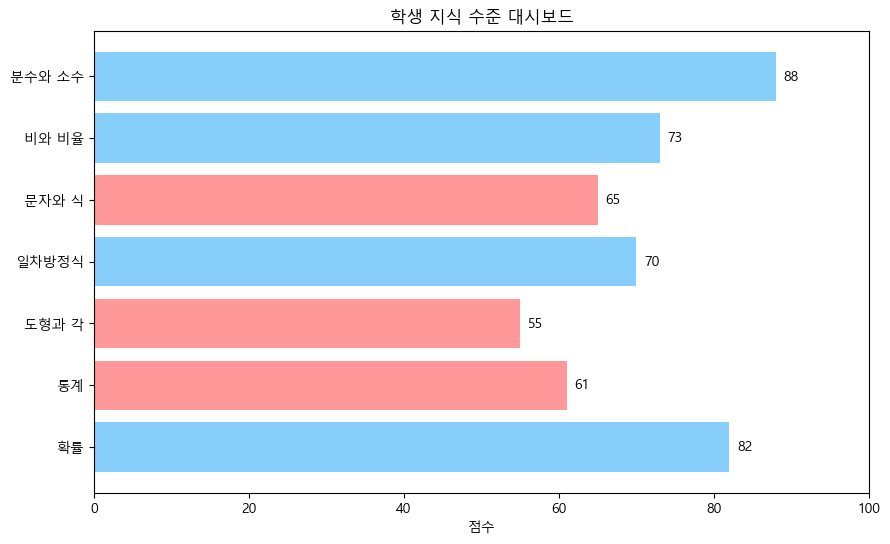

================================ Human Message =================================


                아래 학생의 진단 결과를 바탕으로 학생의 지식 수준을 대시보드에 나타내주세요.
                [
                    { "chapter": "분수와 소수", "score": 88 },
                    { "chapter": "비와 비율", "score": 73 },
                    { "chapter": "문자와 식", "score": 65 },
                    { "chapter": "일차방정식", "score": 70 },
                    { "chapter": "도형과 각", "score": 55 },
                    { "chapter": "통계", "score": 61 },
                    { "chapter": "확률", "score": 82 }
                ]
                
================================== Ai Message ==================================
Tool Calls:
  python_exec_tool (call_gvv77aaPObiH423rrRvkfDCc)
 Call ID: call_gvv77aaPObiH423rrRvkfDCc
  Args:
    code: import matplotlib.pyplot as plt
import numpy as np

# 데이터 설정
chapters = ['분수와 소수', '비와 비율', '문자와 식', '일차방정식', '도형과 각', '통계', '확률']
scores = [88, 73, 65, 70, 55, 61, 82]

# 색상 설정
colors = ['#87CEFA' if score >=

In [10]:
response = dashboard_agent.invoke(
    {
        "messages": [
            {
                "role": "user",
                "content": """
                아래 학생의 진단 결과를 바탕으로 학생의 지식 수준을 대시보드에 나타내주세요.
                [
                    { "chapter": "분수와 소수", "score": 88 },
                    { "chapter": "비와 비율", "score": 73 },
                    { "chapter": "문자와 식", "score": 65 },
                    { "chapter": "일차방정식", "score": 70 },
                    { "chapter": "도형과 각", "score": 55 },
                    { "chapter": "통계", "score": 61 },
                    { "chapter": "확률", "score": 82 }
                ]
                """
            }
        ]
    }
)
for msg in response["messages"]:
    msg.pretty_print()

In [11]:
from typing import Literal

from langchain_core.messages import BaseMessage, HumanMessage
from langgraph.graph import MessagesState, END
from langgraph.types import Command


def get_next_node(last_message: BaseMessage, goto: str):
    if "FINAL ANSWER" in last_message.content:
        return END
    return goto


def dashboard_node(state: MessagesState) -> Command[Literal["problem_agent", END]]:
    result = dashboard_agent.invoke(state)
    goto = get_next_node(result["messages"][-1], "problem_agent")

    result["messages"][-1] = HumanMessage(
        content=result["messages"][-1].content, name="dashboard_agent"
    )

    return Command(
        update={"messages": result["messages"]},
        goto=goto,
    )


def problem_node(state: MessagesState) -> Command[Literal["dashboard_agent", END]]:
    result = problem_agent.invoke(state)
    goto = get_next_node(result["messages"][-1], "dashboard_agent")

    result["messages"][-1] = HumanMessage(
        content=result["messages"][-1].content, name="problem_agent"
    )

    return Command(
        update={"messages": result["messages"]},
        goto=goto,
    )


In [12]:
from langgraph.graph import StateGraph, START

graph_builder = StateGraph(MessagesState)
graph_builder.add_node("dashboard_agent", dashboard_node)
graph_builder.add_node("problem_agent", problem_node)

graph_builder.add_edge(START, "dashboard_agent")

In [13]:
graph = graph_builder.compile()

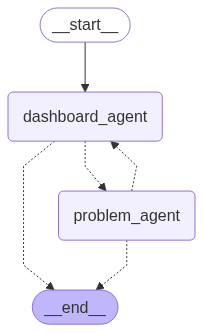

In [14]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    pass

테스트

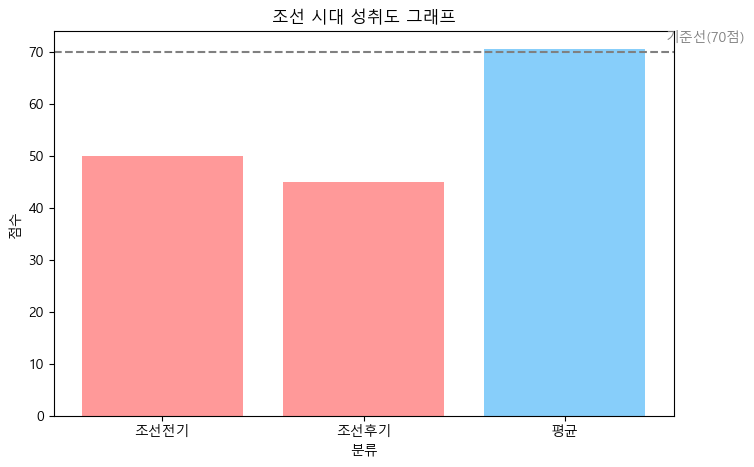

================================ Human Message =================================


                {"조선전기" : 50, "조선후기" : 45}, 평균 점수 : 70.5
                학생이 '조선 전기'와 '조선 후기' 단원에서 낮은 성취도를 보였습니다.

                1. 각 단원에 해당하는 대표적인 조선 왕(예: 태종, 세종, 성종, 영조, 정조 등)에 대해 Wikipedia에서 검색 가능한 고유명사 기반 키워드(예: '세종', '정조', '조선왕조')를 활용해 정보를 조회하세요.

                2. 각 왕에 대해 학습 수준에 적합한 연습 문제를 한 문항씩 생성하세요.  
                문제는 객관식 형식으로, 선택지 4개와 정답을 포함해야 합니다.

                3. 문제는 해당 왕의 업적, 정책, 문화, 제도 등을 중심으로 구성하세요.

                위 내용을 기반으로 문제를 생성하고, 결과만 출력하세요.
                문제를 생성하면 끝내세요.
                
================================== Ai Message ==================================
Tool Calls:
  return_diagnosis (call_gwh0z7HMZxrT3lRaNCEZbRJu)
 Call ID: call_gwh0z7HMZxrT3lRaNCEZbRJu
  Args:
    diagnosis: 학생의 '조선 전기' (조선 초기)와 '조선 후기'에서 낮은 성취도를 보이고 있으며, 평균 점수는 70.5점입니다. 이 분야에서는 추가적인 학습이 필요할 것으로 보입니다.
  python_exec_tool (call_uxYxFbbRYVXRYUCsAMtxOPyc)
 Call ID: call_uxYxFbbRYVXRYUCsAMtxOPyc

In [14]:
response = graph.invoke(
    {
        "messages": [
            (
                "user",
                """
                {"조선전기" : 50, "조선후기" : 45}, 평균 점수 : 70.5
                학생이 '조선 전기'와 '조선 후기' 단원에서 낮은 성취도를 보였습니다.

                1. 각 단원에 해당하는 대표적인 조선 왕(예: 태종, 세종, 성종, 영조, 정조 등)에 대해 Wikipedia에서 검색 가능한 고유명사 기반 키워드(예: '세종', '정조', '조선왕조')를 활용해 정보를 조회하세요.

                2. 각 왕에 대해 학습 수준에 적합한 연습 문제를 한 문항씩 생성하세요.  
                문제는 객관식 형식으로, 선택지 4개와 정답을 포함해야 합니다.

                3. 문제는 해당 왕의 업적, 정책, 문화, 제도 등을 중심으로 구성하세요.

                위 내용을 기반으로 문제를 생성하고, 결과만 출력하세요.
                문제를 생성하면 끝내세요.
                """
            )
        ]
    },
)
for msg in response["messages"]:
    msg.pretty_print()

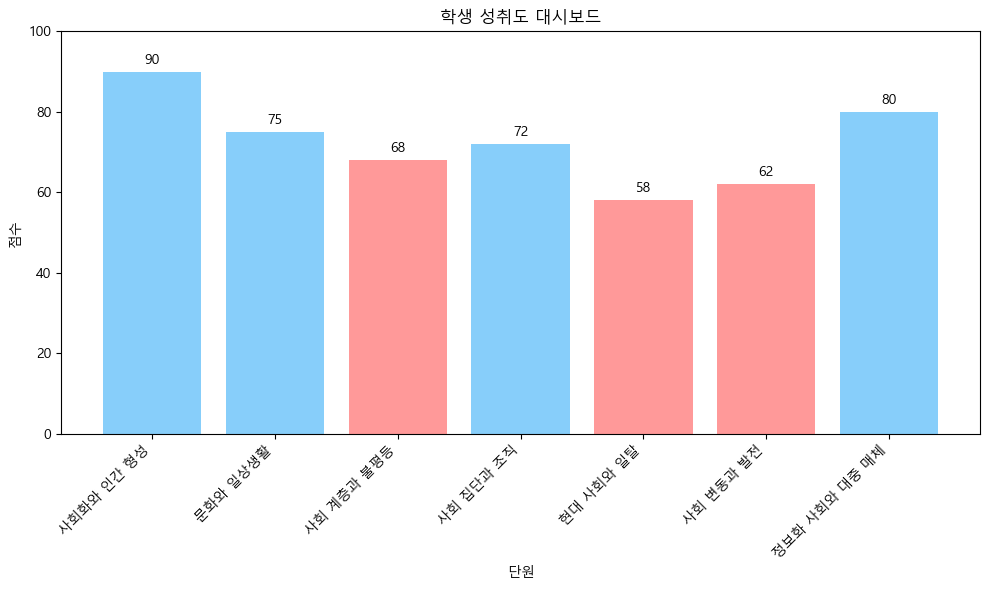

================================ Human Message =================================


                [
                    { "chapter": "사회화와 인간 형성", "score": 90 },
                    { "chapter": "문화와 일상생활", "score": 75 },
                    { "chapter": "사회 계층과 불평등", "score": 68 },
                    { "chapter": "사회 집단과 조직", "score": 72 },
                    { "chapter": "현대 사회와 일탈", "score": 58 },
                    { "chapter": "사회 변동과 발전", "score": 62 },
                    { "chapter": "정보화 사회와 대중 매체", "score": 80 }
                ]

                위 성취도를 가지는 학생의 대시보드 시각화를 해주세요.
                또한 이 학생에게 필요한 연습 모의고사 문제를 생성해주세요.
                문제를 생성하면 끝내세요.
                
================================== Ai Message ==================================
Tool Calls:
  python_exec_tool (call_kB3J3YjpwO4idPgtUrpZ0VVA)
 Call ID: call_kB3J3YjpwO4idPgtUrpZ0VVA
  Args:
    code: import matplotlib.pyplot as plt
import numpy as np

# 학생의 성취도 데이터를 정의합니다.
chapters = ['사회화와 인간 형성', '문

In [15]:
response = graph.invoke(
    {
        "messages": [
            (
                "user",
                """
                [
                    { "chapter": "사회화와 인간 형성", "score": 90 },
                    { "chapter": "문화와 일상생활", "score": 75 },
                    { "chapter": "사회 계층과 불평등", "score": 68 },
                    { "chapter": "사회 집단과 조직", "score": 72 },
                    { "chapter": "현대 사회와 일탈", "score": 58 },
                    { "chapter": "사회 변동과 발전", "score": 62 },
                    { "chapter": "정보화 사회와 대중 매체", "score": 80 }
                ]

                위 성취도를 가지는 학생의 대시보드 시각화를 해주세요.
                또한 이 학생에게 필요한 연습 모의고사 문제를 생성해주세요.
                문제를 생성하면 끝내세요.
                """
            )
        ]
    },
)
for msg in response["messages"]:
    msg.pretty_print()